# An Introduction to BSpy

* Dr. Eric Brechner, Ally for Onlys in Tech
* Dr. Thomas Grandine, University of Washington

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline
import bspy

# Instead of polynomials, let's use piecewise polynomials

* Piecewise polynomial functions are often called **splines**.
    * Allows for higher dimension function spaces without high degree polynomials
    * Supports local refinement
* Everyone knows at least one spline function

$$|x|=\begin{cases}\begin{matrix}-x\qquad\hbox{for }x<0\cr x\qquad\hbox{for }x\ge 0\cr\end{matrix}\end{cases}$$

# What is the usual spline setup

* In general, splines are defined over an interval $[t_0,t_n]$ (the **domain**).
* Intermediate points $t_i$ are chosen so that $t_0<t_1<...<t_n$ and the spline function $s$ is the collection of polynomials $p_i$ of degree $k$ satisfying

$$s(t) = p_i(t)\qquad\hbox{if }t_i\le t\lt t_{i+1}$$

* Because the polynomials are tied together at the points $t_i$, those points are usually called **knots**.
* Additionally, the polynomials frequently chosen so that the spline function is continuous

$$p_{i-1}(t_i)=p_i(t_i)$$

* Derivative conditions are also often enforced

$$p_{i-1}'(t_i)=p_i'(t_i)$$

# B-splines form a basis for a function space of splines

* Any spline function $s$ can be written as a linear combination of B-splines

$$s(t)=\sum_{i=0}^n\alpha_iB_i(t)$$

* The basis functions $B_i$ are determined by
    * The polynomial degree of the polynomials
    * The knots of the spline
    * The continuity conditions across the knots

(-0.05, 1.05, -0.14500000000000002, 0.8450000000000001)

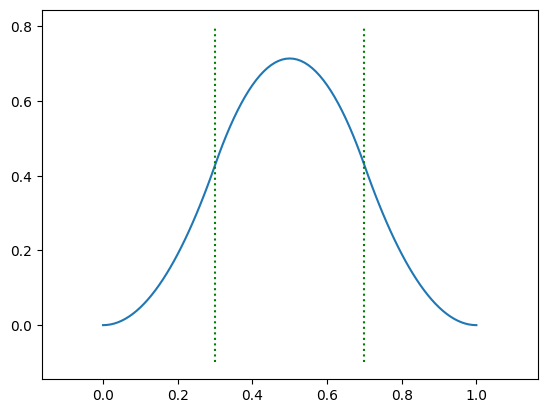

In [2]:
# The `Spline` constructor is the most basic method in BSpy

b2 = bspy.Spline(1,      # <== Number of independent variables
                 1,      # <== Number of dependent variables
                 [3],    # <== Polynomial order in each independent variable
                 [5],    # <== Number of B-splines in each independent variable
                 [[0.0, 0.0, 0.0, 0.3, 0.7, 1.0, 1.0, 1.0]],    # <== Knot sequence in each independent variable
                 [[0.0, 0.0, 1.0, 0.0, 0.0]])    # <== B-spline coefficients in each dependent variable
tValues = np.linspace(0.0, 1.0, 101)
plt.plot(tValues, b2(tValues))      # The __call__ method supports function evaluation and numpy ufuncs
plt.plot([0.3, 0.3], [-0.1, 0.8], 'g', linestyle = ':')
plt.plot([0.7, 0.7], [-0.1, 0.8], 'g', linestyle = ':')
plt.axis('equal')

(-0.05, 1.05, -0.15500000000000003, 1.055)

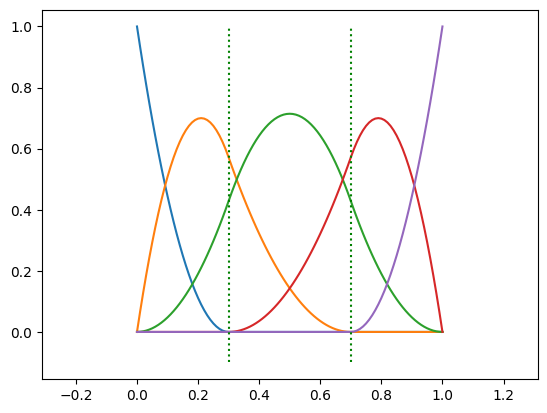

In [3]:
bi = bspy.Spline(1, 1, [3], [5], [[0.0, 0.0, 0.0, 0.3, 0.7, 1.0, 1.0, 1.0]], [[0.0, 0.0, 0.0, 0.0, 0.0]])
for i in range(bi.nCoef[0]):
    bi.coefs[0][i] = 1.0
    plt.plot(tValues, bi(tValues))
    bi.coefs[0][i] = 0.0
plt.plot([0.3, 0.3], [-0.1, 1.0], 'g', linestyle = ':')
plt.plot([0.7, 0.7], [-0.1, 1.0], 'g', linestyle = ':')
plt.axis('equal')

# BSpy is designed to work in any dimension

* Points can be represented as zero dimensional splines (i.e. with 0 independent variables)
* Curves can be represented as one dimensional splines
* Surfaces can be represented as two dimensional splines
* Volumetric solids can be represented as three dimensional splines

In [4]:
# BSpy is also designed to work seamlessly with numpy, scipy, and matplotlib

myPoint = bspy.Spline.point([1.0, 2.0, 3.0])
myPoint()

array([1., 2., 3.])

In [5]:
# Basic fitting can be accomplished with the `least_squares` method

def myFunction(t):
    return 1.0 + 0.25 * np.cos(6.0 * np.pi * t)
tValues = np.linspace(0.0, 1.0, 51)
xValues = [[myFunction(t) for t in tValues]]
mySpline = bspy.Spline.least_squares(tValues, xValues, tolerance = 0.001)
print(mySpline)

Spline(1, 1, (4,), (22,), (array([0.       , 0.       , 0.       , 0.       , 0.0625   , 0.125    ,
       0.1875   , 0.25     , 0.3125   , 0.375    , 0.4375   , 0.5      ,
       0.515625 , 0.5234375, 0.53125  , 0.5625   , 0.625    , 0.6875   ,
       0.75     , 0.8125   , 0.875    , 0.9375   , 1.       , 1.       ,
       1.       , 1.       ]),) [[1.24996475 1.25224921 1.12006833 0.77697982 0.70796513 0.99999611
  1.29204425 1.22300505 0.8799615  0.73117493 0.75795927 0.7717875
  0.810252   0.93712147 1.22299919 1.29204904 0.99999332 0.70796671
  0.77697887 1.12006905 1.25224883 1.24996479]], {})


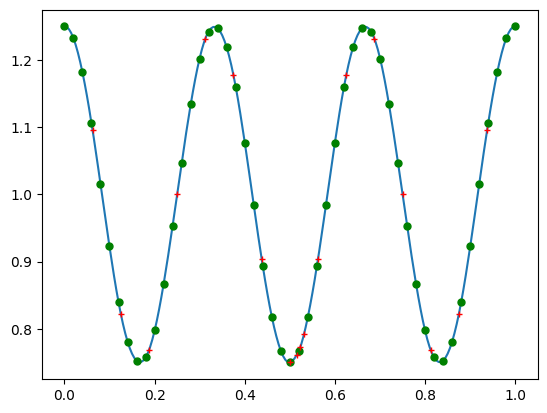

In [6]:
tPlot = np.linspace(0.0, 1.0, 201)
xPlot = mySpline(tPlot)
knots = mySpline.knots[0][mySpline.order[0] : -mySpline.order[0]]
kPlot = mySpline(knots)
plt.plot(tPlot, xPlot)
plt.plot(tValues, xValues[0], 'g', marker = 'o', markersize = 5, linestyle = "")
plt.plot(knots, kPlot, 'r', marker = '+', markersize = 5, linestyle = "")

In [7]:
# mySpline is a function, so it can be evaluated

print(mySpline(0.1218))

# Other operations can be performed

myDerivative = mySpline.differentiate()
print(myDerivative)

[0.8335585]
Spline(1, 1, (3,), (21,), (array([0.       , 0.       , 0.       , 0.0625   , 0.125    , 0.1875   ,
       0.25     , 0.3125   , 0.375    , 0.4375   , 0.5      , 0.515625 ,
       0.5234375, 0.53125  , 0.5625   , 0.625    , 0.6875   , 0.75     ,
       0.8125   , 0.875    , 0.9375   , 1.       , 1.       , 1.       ]),) [[ 0.10965377 -3.17234097 -5.48941622 -1.10423501  4.67249563  4.67277031
  -1.1046273  -5.48869671 -3.17411366  0.93501697  1.32751039  2.46172783
   3.74752909  5.48885218  1.10479763 -4.67289153 -4.67242581  1.10419468
   5.48944284  3.17231478 -0.1096341 ]], {})


(-0.062498237743659424,
 1.3124629926168494,
 -0.062498239479337504,
 1.3124630290660875)

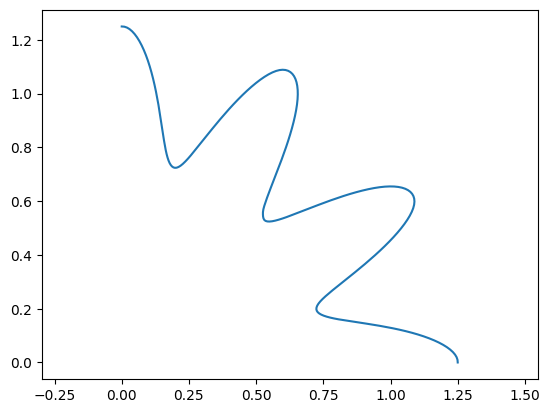

In [8]:
# Spline arithmetic is supported

myCurve = mySpline * bspy.Spline.circular_arc(1.0, 90.0)
xPlot, yPlot = myCurve(tPlot)
plt.plot(xPlot, yPlot)
plt.axis('equal')

In [9]:
flower = myCurve.revolve(360.0)
viewer = bspy.Viewer()
viewer.draw(flower, 'flower')
viewer.mainloop()

# The BSpy `section` method is shape preserving

* Given two points $(x_i, y_i, \theta_i, \kappa_i),\quad i = 0, 1$, fit a parametric quartic polynomial curve that interpolates the data

$$\begin{align}
x(0) &= x_0\cr
y(0) &= y_0\cr
\begin{pmatrix}x'(0)\cr y'(0)\cr\end{pmatrix}\times\begin{pmatrix}\cos\theta_0\cr \sin\theta_0\cr\end{pmatrix} &= 0\cr
\kappa(0) &= \kappa_0\cr
x(1) &= x_1\cr
y(1) &= y_1\cr
\begin{pmatrix}x'(1)\cr y'(1)\cr\end{pmatrix}\times\begin{pmatrix}\cos\theta_1\cr \sin\theta_1\cr\end{pmatrix} &= 0\cr
\kappa(1) &= \kappa_1\cr
\end{align}$$

* Splines can be constructed by stitching together the polynomial pieces
* The `section` method accepts sequences of $n$ points
* The method is $O(h^6)$ in general, $O(h^8)$ for conic section data

(0.24999999999999994, 1.35, -0.05, 1.05)

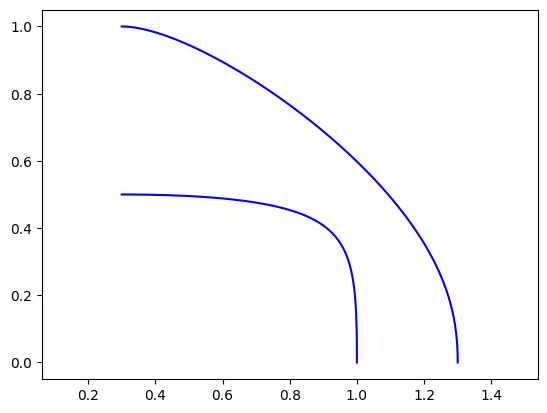

In [10]:
outerSection = bspy.Spline.section([[1.3, 0.0, 90.0, 1.0], [0.3, 1.0, 180.0, 5.0]])
innerSection = bspy.Spline.section([[1.0, 0.0, 90.0, 0.1], [0.3, 0.5, 180.0, 0.2]])
xOuter, yOuter = outerSection(tPlot)
xInner, yInner = innerSection(tPlot)
plt.plot(xOuter, yOuter, color = 'b')
plt.plot(xInner, yInner, color = 'b')
plt.axis('equal')

(0.24999999999999994, 1.35, -0.05, 1.05)

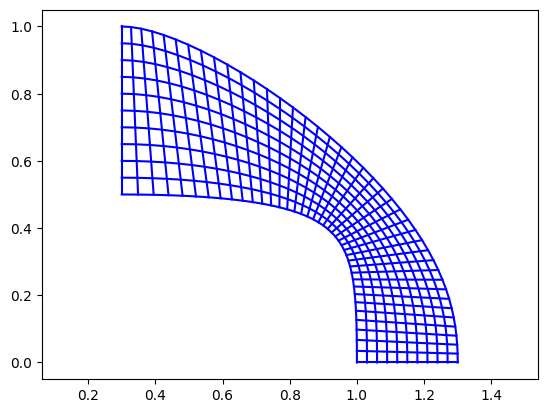

In [12]:
region2D = bspy.Spline.ruled_surface(outerSection, innerSection)
uValues = np.linspace(0.0, 1.0, 41)
vValues = np.linspace(0.0, 1.0, 11)
u, v = np.meshgrid(uValues, vValues)
uMesh, vMesh = region2D(u, v)
plt.plot(uMesh, vMesh, color = 'b')
plt.plot(np.transpose(uMesh), np.transpose(vMesh), color = 'b')
plt.axis('equal')

In [13]:
sweptVolume = region2D.revolve(120.0)
viewer = bspy.Viewer()
viewer.draw(sweptVolume, 'sweptVolume')
viewer.mainloop()

# It's useful to be able to evaluate this integral

$$\int_\Omega f(x(u)){dV\over du}du$$

* $x$ is a tensor product spline defined over a domain $\Omega$
* $dV\over du$ is the volume measure of the spline
* $f$ is a given, smooth, black box function

In [14]:
sweptVolume.integral()

0.6338696791641663

# Many interesting problems can be solved with contouring

* Consider

$$f:\mathbb{R}^n\to\mathbb{R}^{n-1}$$

* Want to solve

$$f(x)=0$$

* Typically has a one parameter family of solutions
* Want to find a mapping

$$x:[0,1]\to\mathbb{R}^n$$

* The problem is typically not well-posed

$$f(x(t))=0\quad\hbox{implies}\quad f(x(t^2))=0$$

# The problem can be made well-posed

* Need to solve

$$\begin{align}
f(x)&=0\cr
x'\cdot x''&=0\cr
\end{align}$$

(-0.05, 1.05, -0.00847098824910918, 0.17789075323129278)

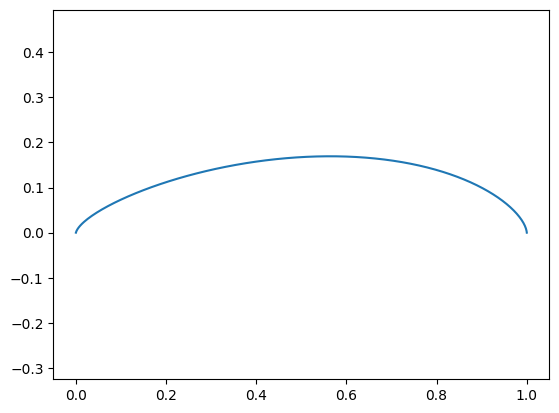

In [20]:
section1 = bspy.Spline.section([[0.0, 0.0, 75.0, -50.0], [1.0, 0.0, -85.0, -30.0]])
xPlot, yPlot = section1(tPlot)
plt.plot(xPlot, yPlot)
plt.axis("equal")

Spline(1, 2, (5,), (5,), (array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]),) [[1.         1.09264525 1.29891841 1.4697502  1.5       ]
 [0.         0.34575676 0.45549909 0.34575676 0.        ]], {})


(0.975, 1.525, -0.01718452694803375, 0.36087506590870877)

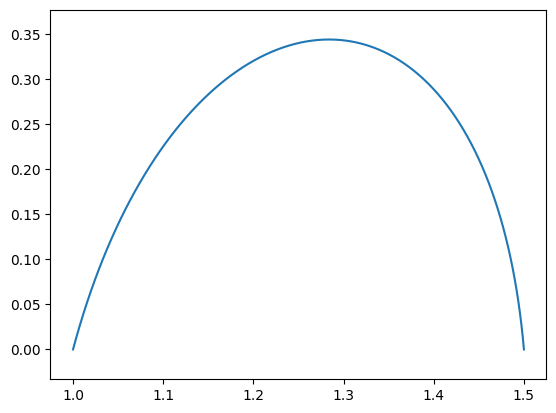

In [21]:
section2 = bspy.Spline.section([[1.0, 0.0, 75.0, -1.0], [1.5, 0.0, -85.0, -1.0]])
print(section2)
xPlot, yPlot = section2(tPlot)
plt.plot(xPlot, yPlot)
plt.axis("equal")

In [22]:
section1_3D = [[1.0, 0.0], [0.0, 0.0], [0.0, 1.0]] @ section1
section2_3D = [[1.0, 0.0], [0.0, 0.0], [0.0, 1.0]] @ section2 + [0.0, 1.0, 0.0]
ruled = bspy.Spline.ruled_surface(section1_3D, section2_3D)
viewer = bspy.Viewer()
viewer.draw(ruled, 'ruled')
viewer.mainloop()

In [23]:
cValues = np.linspace(0.0, 1.0, 41)
curvatures = np.array([ruled.curvature([u, v]) for u in cValues for v in cValues])
print(np.min(curvatures), np.max(curvatures))

-0.5245176246541546 -0.0


# Developable surfaces can be created with contouring

* Need to have $c_1'(u)$, $c_2'(v)$, $c_1(u)-c_2(v)$ be coplanar for all values of $u$ and $v$
* This can be achieved by solving

$$\det\left|c_1'(u)\quad c_2'(v)\quad c_1(u)-c_2(v)\right|=0$$

* This can be rewritten as

$$c_1'(u)\times c_2'(v)\cdot(c_1(u)-c_2(v))=0$$

In [24]:
section1_tan = section1_3D.differentiate()
section2_tan = section2_3D.differentiate()
s1xs2 = section1_tan.multiply(section2_tan, productType = 'C')
s1ms2 = section1_3D.subtract(section2_3D)
determinant = s1xs2 @ s1ms2
print(determinant)

Spline(2, 1, (8, 8), (8, 8), (array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])) [[[ 4.16333634e-16 -1.06415012e-01 -1.82045189e-01 -2.29007865e-01
   -2.49420376e-01 -2.45400056e-01 -2.19064239e-01 -1.72530261e-01]
  [ 1.35024678e+00  7.66019727e-01  2.45754064e-01 -2.18003806e-01
   -6.32707483e-01 -1.00581057e+00 -1.34476665e+00 -1.65702934e+00]
  [ 2.11590077e+00  1.33809057e+00  6.20675250e-01 -4.52855063e-02
   -6.68732000e-01 -1.25860454e+00 -1.82384343e+00 -2.37338897e+00]
  [ 2.38259773e+00  1.62509713e+00  9.01366889e-01  2.03694581e-01
   -4.75632205e-01 -1.14432588e+00 -1.81009887e+00 -2.48066357e+00]
  [ 2.23597340e+00  1.64233901e+00  1.04647750e+00  4.43484001e-01
   -1.71546377e-01 -8.03518509e-01 -1.45733728e+00 -2.13790756e+00]
  [ 1.76166355e+00  1.40511581e+00  1.01465561e+00  5.88630300e-01
    1.25387207e-01 -3.76726325e-01 -9.19362956e-01 -1.50417535e+00]
  [ 1.04530391

(-0.05, 1.05, -0.04999999999999952, 1.0499999999999898)

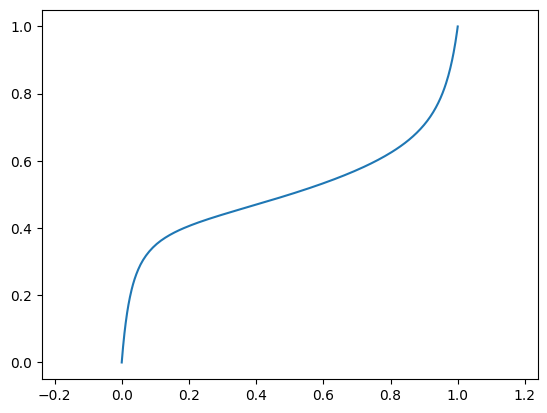

In [25]:
[u1u2] = determinant.contours()
u1, u2 = u1u2(tPlot)
plt.plot(u1, u2)
plt.axis('equal')

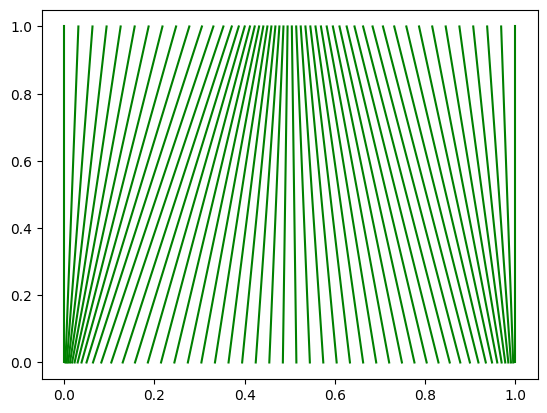

In [26]:
u1Fit, u2Fit = u1u2(tValues)
for u1, u2 in zip(u1Fit, u2Fit):
    plt.plot([u1, u2], [0.0, 1.0], 'g')

In [27]:
bottom = bspy.Spline.composition([section1_3D, [1.0, 0.0] @ u1u2])
top = bspy.Spline.composition([section2_3D, [0.0, 1.0] @ u1u2])
developable = bspy.Spline.ruled_surface(bottom, top)
viewer = bspy.Viewer()
viewer.set_fill_color(developable, 0.1, 0.3, 0.9)
viewer.draw(developable, 'developable')
viewer.mainloop()

In [ ]:
blob = bspy.Spline.section([[1.0, 0.0, 90.0, 0.2], [0.0, 1.0, 180.0, 0.2], [-0.5, 0.5, 320.0, 0.0],
                            [-0.5, -0.5, 220.0, 0.0], [0.0, -1.0, 0.0, 5.0], [1.0, 0.0, 90.0, 0.2]])
xBlob, yBlob = blob(tPlot)
plt.plot(xBlob, yBlob)
plt.axis('equal')

In [ ]:
trajectory = bspy.Spline(1, 2, [4], [4], [[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]],
                         [[0.0, 0.0], [0.0, 1.5], [2.0, 1.0], [2.0, 2.0]])
xT, yT = trajectory(tPlot)
plt.plot(xT, yT)
plt.plot('equal')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim((-1, 3.5))
ax.set_ylim((-1, 3.5))
line, = ax.plot([], [], lw=2)
ax.plot(xT, yT)

# initialization function: plot the background of each frame

def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially

def animate(i):
    xPlot = xBlob + xT[i]
    yPlot = yBlob + yT[i]
    line.set_data(xPlot, yPlot)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=201, interval=20, blit=True)
HTML(anim.to_html5_video())

In [ ]:
blob_u = blob.differentiate()
blob_t = trajectory.differentiate()
blob_tangents = blob_u.multiply(blob_t, productType = 'C')
envelopes = []
for ut in blob_tangents.contours():
    uValues, timeValues = ut(tPlot)
    envelopes.append(np.array([blob(uValue) + trajectory(timeValue) for uValue, timeValue in zip(uValues, timeValues)]).T)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim((-1, 3.5))
ax.set_ylim((-1, 3.5))
line, = ax.plot([], [], lw=2)
for envelope in envelopes:
    ax.plot(*envelope)

# initialization function: plot the background of each frame

def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially

def animate(i):
    xPlot = xBlob + xT[i]
    yPlot = yBlob + yT[i]
    line.set_data(xPlot, yPlot)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=201, interval=20, blit=True)
HTML(anim.to_html5_video())

In [ ]:
# The `Spline` class has many methods, with more to come

dir(bspy.Spline)

# A great many things remain to be done

* Enable `least_squares` to accept black box functions as input
* STEP and IGES file support
* Mass properties for B-rep solids
* Multivariate finite elements
* NC machining tool path creation
* Support for 3D printing
* Explore and exploit the `SplineBlock` object
* ***Encourage others to enrich BSpy with their own contributions***